<a href="https://colab.research.google.com/github/raviakasapu/LLM-Training-Docs/blob/main/1_embedding_models_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data from hugging face using load_dataset

In [2]:
# Hide output in Google Colab
from IPython.display import display, Javascript

def hide_output():
    display(Javascript('''
        var cell = Jupyter.notebook.get_selected_cell();
        var cell_index = Jupyter.notebook.get_selected_index();
        var cell_element = Jupyter.notebook.get_cell_element(cell_index);
        cell_element.find('.output').hide();
    '''))

### installation & Datasets

In [3]:
!pip install datasets -q
!pip install wandb -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.0 MB/s eta 0:00:00


In [10]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: raviakasapu to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [11]:
from datasets import load_dataset

 data from https://huggingface.co/datasets/sentence-transformers/all-nli

In [12]:
hide_output
train_dataset = load_dataset("sentence-transformers/all-nli", "pair-class", split="train")
test_dataset = load_dataset("sentence-transformers/all-nli", "pair-class", split="test")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/69.5M [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/942069 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/19657 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19656 [00:00<?, ? examples/s]

In [13]:
print(train_dataset)

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 942069
})


In [14]:
print(test_dataset)

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 19656
})


### Loss Function

list of loss functions https://sbert.net/docs/sentence_transformer/loss_overview.html



*   Choose loss funtion depending on data and task (usecase)
  similarity sores - user `CoSENTLoss`, `AnglELoss`, `CosineSimilarityLoss`
*   



### Load Model

In [15]:
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    SentenceTransformerModelCardData,
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [16]:
hide_output()
model = SentenceTransformer('FacebookAI/xlm-roberta-base')

<IPython.core.display.Javascript object>

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

### Training Arguments

In [17]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.evaluation import TripletEvaluator

In [18]:
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="models/mpnet-base-all-nli-triplet",
    # Optional training parameters:
    num_train_epochs=1, # number of epochs to run for training
    per_device_train_batch_size=16, # batch size for training , def: 8
    per_device_eval_batch_size=16, # batch size for eval def:8
    warmup_ratio=0.1, # optional, number of training steps
    fp16=False,  # Set to False if your GPU can't handle FP16
    bf16=False,  # Set to True if your GPU supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # Losses using "in-batch negatives" benefit from no duplicates
    # Optional tracking/debugging parameters:
    eval_strategy="steps", # no, steps, epoch
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    run_name="mpnet-base-all-nli-triplet",  # Used in W&B if `wandb` is installed
)

#other parameters

# log_level : debug, info, warning, error, critical

### training job for new model

In [19]:
"""
The system trains BERT (or any other transformer model like RoBERTa, DistilBERT etc.) on the SNLI + MultiNLI (AllNLI) dataset
with MultipleNegativesRankingLoss. Entailments are positive pairs and the contradiction on AllNLI dataset is added as a hard negative.
At every 10% training steps, the model is evaluated on the STS benchmark dataset

Usage:
python training_nli_v2.py

OR
python training_nli_v2.py pretrained_transformer_model_name
"""

import logging
import sys
import traceback
from datetime import datetime

from datasets import load_dataset

from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.similarity_functions import SimilarityFunction
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import BatchSamplers, SentenceTransformerTrainingArguments

# Set the log level to INFO to get more information
logging.basicConfig(format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO)


In [49]:

model_name = "answerdotai/ModernBERT-base" #sys.argv[1] if len(sys.argv) > 1 else "distilroberta-base"
train_batch_size = 128  # The larger you select this, the better the results (usually). But it requires more GPU memory
max_seq_length = 75
num_epochs = 1

# Save path of the model
output_dir = (
    "output/training_nli_v2_" + model_name.replace("/", "-") + "-" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)


In [21]:
output_dir

'output/training_nli_v2_answerdotai-ModernBERT-base-2025-02-22_23-00-58'

In [50]:

# 1. Here we define our SentenceTransformer model. If not already a Sentence Transformer model, it will automatically
# create one with "mean" pooling.
model = SentenceTransformer(model_name)

In [23]:
# 2. Load the AllNLI dataset: https://huggingface.co/datasets/sentence-transformers/all-nli
# We'll start with 10k training samples, but you can increase this to get a stronger model
logging.info("Read AllNLI train dataset")
train_dataset = load_dataset("sentence-transformers/all-nli", "triplet", split="train").select(range(10000))
eval_dataset = load_dataset("sentence-transformers/all-nli", "triplet", split="dev").select(range(1000))
logging.info(train_dataset)

train-00000-of-00001.parquet:   0%|          | 0.00/38.4M [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/782k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/810k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/557850 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/6584 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6609 [00:00<?, ? examples/s]

In [24]:
# 3. Define our training loss: https://sbert.net/docs/package_reference/sentence_transformer/losses.html#multiplenegativesrankingloss
train_loss = losses.MultipleNegativesRankingLoss(model)


In [25]:

# 4. Define an evaluator for use during training. This is useful to keep track of alongside the evaluation loss.
stsb_eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

README.md:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/471k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/142k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/108k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [26]:
dev_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=stsb_eval_dataset["sentence1"],
    sentences2=stsb_eval_dataset["sentence2"],
    scores=stsb_eval_dataset["score"],
    main_similarity=SimilarityFunction.COSINE,
    name="sts-dev",
)

In [27]:
logging.info("Evaluation before training:")
dev_evaluator(model)

{'sts-dev_pearson_cosine': 0.5190739554042454,
 'sts-dev_spearman_cosine': 0.556635710740961}

In [28]:
# 5. Define the training arguments
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir=output_dir,
    # Optional training parameters:
    num_train_epochs=1,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=train_batch_size,
    warmup_ratio=0.1,
    fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    save_steps=10,
    save_total_limit=2,
    logging_steps=100,
    run_name="nli-v2",  # Will be used in W&B if `wandb` is installed
)

In [29]:
# 6. Create the trainer & start training
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=train_loss,
    evaluator=dev_evaluator,
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [30]:
trainer.train()

wandb: Currently logged in as: raviakasapu to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss,Validation Loss,Sts-dev Pearson Cosine,Sts-dev Spearman Cosine
10,No log,2.927635,0.719486,0.737611
20,No log,1.637324,0.767050,0.772124
30,No log,1.580626,0.757496,0.767573
40,No log,1.707138,0.748493,0.761263
50,No log,1.760366,0.752380,0.764048
60,No log,1.785103,0.754653,0.766483
70,No log,1.902864,0.750082,0.764296


TrainOutput(global_step=79, training_loss=1.6257546340362936, metrics={'train_runtime': 221.3347, 'train_samples_per_second': 45.18, 'train_steps_per_second': 0.357, 'total_flos': 0.0, 'train_loss': 1.6257546340362936, 'epoch': 1.0})

In [31]:
# 7. Evaluate the model performance on the STS Benchmark test dataset
test_dataset = load_dataset("sentence-transformers/stsb", split="test")
test_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=test_dataset["sentence1"],
    sentences2=test_dataset["sentence2"],
    scores=test_dataset["score"],
    main_similarity=SimilarityFunction.COSINE,
    name="sts-test",
)

In [32]:
test_evaluator(model)

{'sts-test_pearson_cosine': 0.6960229997567589,
 'sts-test_spearman_cosine': 0.689295049927495}

In [33]:
# 8. Save the trained & evaluated model locally
final_output_dir = f"{output_dir}/final"
model.save(final_output_dir)

In [37]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
The token `hf_sent_colab` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate 

In [38]:
model_name = model_name if "/" not in model_name else model_name.split("/")[-1]
model.push_to_hub(f"{model_name}-nli-v2")

model.safetensors:   0%|          | 0.00/596M [00:00<?, ?B/s]

'https://huggingface.co/ravi259/ModernBERT-base-nli-v2/commit/3205fbc6b9972066d47a8a615626147f53fabeb9'

### Test

In [51]:
finetuned_model = SentenceTransformer("ravi259/ModernBERT-base-nli-v2")

In [56]:
# Run inference
sentences = [
  "The cat sat on the windowsill, watching the birds outside.",
  "Quantum computing has the potential to revolutionize cryptography.",
  "A delicious homemade pizza requires fresh ingredients and patience.",
  "The stock market fluctuates based on economic and political events.",
  "Machine learning models improve with more diverse and high-quality data.",
  "Quantum computing SOLVES many problems in stock market."
]

In [57]:
f_embeddings = finetuned_model.encode(sentences)
embeddings = model.encode(sentences)

similarities = model.similarity(embeddings, embeddings)
print(similarities)

# Get the similarity scores for the embeddings
f_similarities = finetuned_model.similarity(f_embeddings, f_embeddings)
print(f_similarities)

tensor([[1.0000, 0.9052, 0.9002, 0.9080, 0.8959, 0.8925],
        [0.9052, 1.0000, 0.8940, 0.9162, 0.9148, 0.9144],
        [0.9002, 0.8940, 1.0000, 0.8995, 0.9033, 0.8940],
        [0.9080, 0.9162, 0.8995, 1.0000, 0.9209, 0.9153],
        [0.8959, 0.9148, 0.9033, 0.9209, 1.0000, 0.9142],
        [0.8925, 0.9144, 0.8940, 0.9153, 0.9142, 1.0000]])
tensor([[1.0000, 0.3817, 0.3830, 0.3936, 0.3612, 0.4211],
        [0.3817, 1.0000, 0.4469, 0.5501, 0.5800, 0.6188],
        [0.3830, 0.4469, 1.0000, 0.4487, 0.4868, 0.5096],
        [0.3936, 0.5501, 0.4487, 1.0000, 0.5981, 0.5528],
        [0.3612, 0.5800, 0.4868, 0.5981, 1.0000, 0.5553],
        [0.4211, 0.6188, 0.5096, 0.5528, 0.5553, 1.0000]])


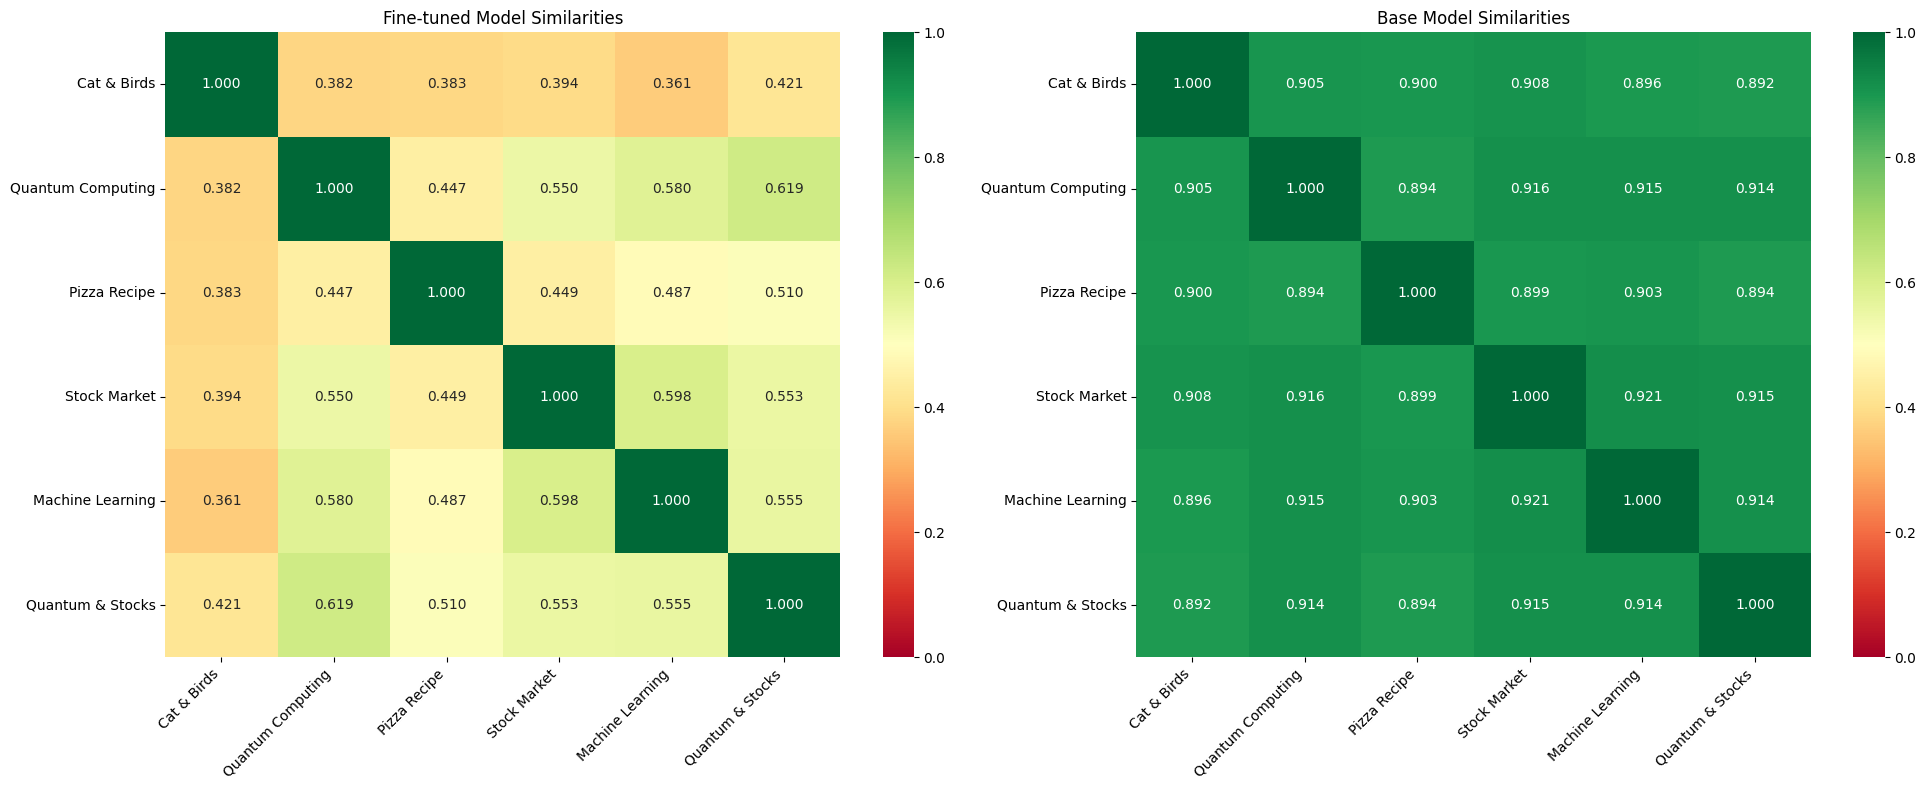

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

labels = [
    "Cat & Birds",
    "Quantum Computing",
    "Pizza Recipe",
    "Stock Market",
    "Machine Learning",
    "Quantum & Stocks"
]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot fine-tuned model heatmap with red-to-green colormap
sns.heatmap(f_similarities, annot=True, cmap='RdYlGn', vmin=0, vmax=1, ax=ax1,
            xticklabels=labels, yticklabels=labels, fmt='.3f')
ax1.set_title('Fine-tuned Model Similarities')

# Plot base model heatmap with red-to-green colormap
sns.heatmap(similarities, annot=True, cmap='RdYlGn', vmin=0, vmax=1, ax=ax2,
            xticklabels=labels, yticklabels=labels, fmt='.3f')
ax2.set_title('Base Model Similarities')

# Rotate x-axis labels for better readability
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

In [68]:
sentences = [
    "The quick brown fox, known for its agility and cunning, swiftly jumped over the lazy dog, who barely lifted its head in response to the sudden movement.",
    "As artificial intelligence continues to advance, researchers are exploring its potential applications in various fields, including medicine, finance, and creative industries, raising both excitement and ethical concerns.",
    "In a quiet village nestled between towering mountains, an old librarian spent her days meticulously restoring ancient manuscripts, preserving the knowledge and stories of generations long past.",
    "Despite the turbulent market conditions, the company's innovative approach to renewable energy solutions positioned it as a leader in the industry, attracting investors who prioritized sustainability and long-term growth.",
    "The astronaut gazed out of the spacecraft window, mesmerized by the vast expanse of the universe, where countless stars twinkled against the backdrop of infinite darkness, a humbling reminder of humanity's small place in the cosmos."
]

In [66]:
def compare_plot(sentences):
  embeddings = model.encode(sentences)
  f_embeddings = finetuned_model.encode(sentences)
  similarities = model.similarity(embeddings, embeddings)
  f_similarities = finetuned_model.similarity(f_embeddings, f_embeddings)

  labels = [
    "Cat & Birds",
    "Quantum Computing",
    "Pizza Recipe",
    "Stock Market",
    "Machine Learning"
  ]

  # Create a figure with two subplots side by side
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

  # Plot fine-tuned model heatmap with red-to-green colormap
  sns.heatmap(f_similarities, annot=True, cmap='RdYlGn', vmin=0, vmax=1, ax=ax1,
              xticklabels=labels, yticklabels=labels, fmt='.3f')
  ax1.set_title('Fine-tuned Model Similarities')

  # Plot base model heatmap with red-to-green colormap
  sns.heatmap(similarities, annot=True, cmap='RdYlGn', vmin=0, vmax=1, ax=ax2,
              xticklabels=labels, yticklabels=labels, fmt='.3f')
  ax2.set_title('Base Model Similarities')

  # Rotate x-axis labels for better readability
  plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
  plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

  # Adjust layout to prevent label cutoff
  plt.tight_layout()
  plt.show()

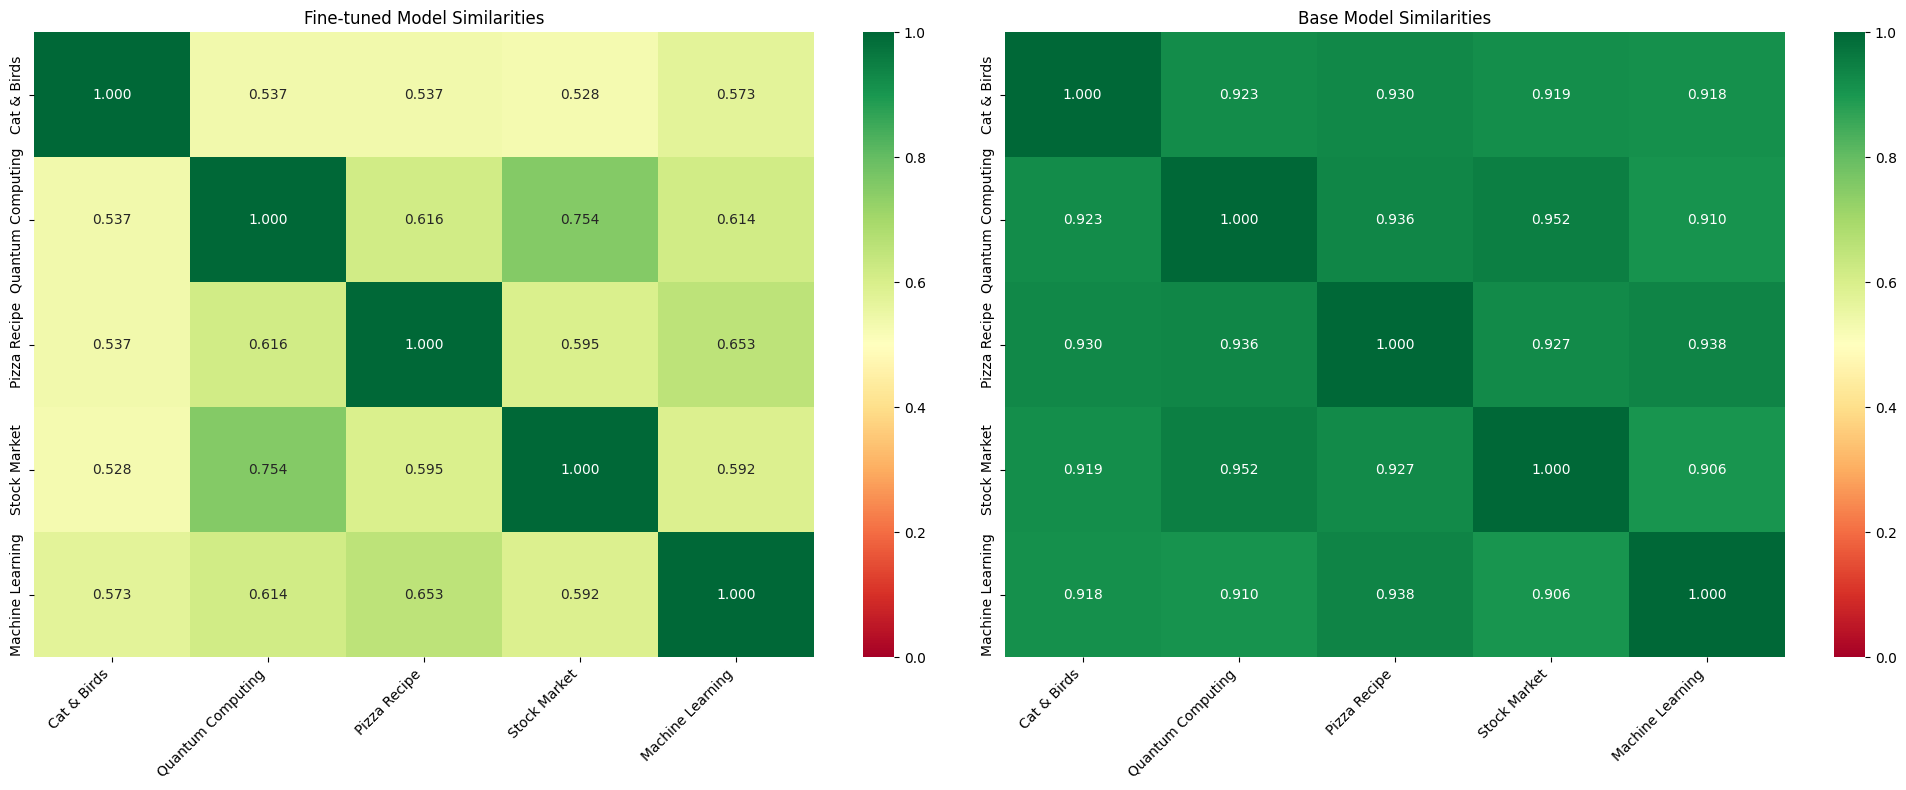

In [69]:
compare_plot(sentences)

In [70]:
sentences = [
  "The rapid advancements in artificial intelligence have led to groundbreaking innovations in fields such as healthcare, finance, and autonomous systems, transforming the way businesses and individuals interact with technology.",
  "As climate change accelerates, scientists and policymakers around the world are working together to develop sustainable solutions that reduce carbon emissions, promote renewable energy, and protect vulnerable ecosystems from further degradation.",
  "The unexpected rise of a small startup in the competitive tech industry demonstrated the power of strategic decision-making, innovative product design, and an agile workforce capable of adapting to rapid market changes.",
  "In an effort to improve global education standards, organizations are leveraging online learning platforms to provide high-quality, accessible courses to students in remote and underserved areas, bridging the digital divide and empowering future generations.",
  "While quantum computing remains in its early stages, researchers are making significant strides in developing stable qubits, reducing decoherence, and exploring practical applications that could revolutionize fields such as cryptography, materials science, and complex optimization problems."

]

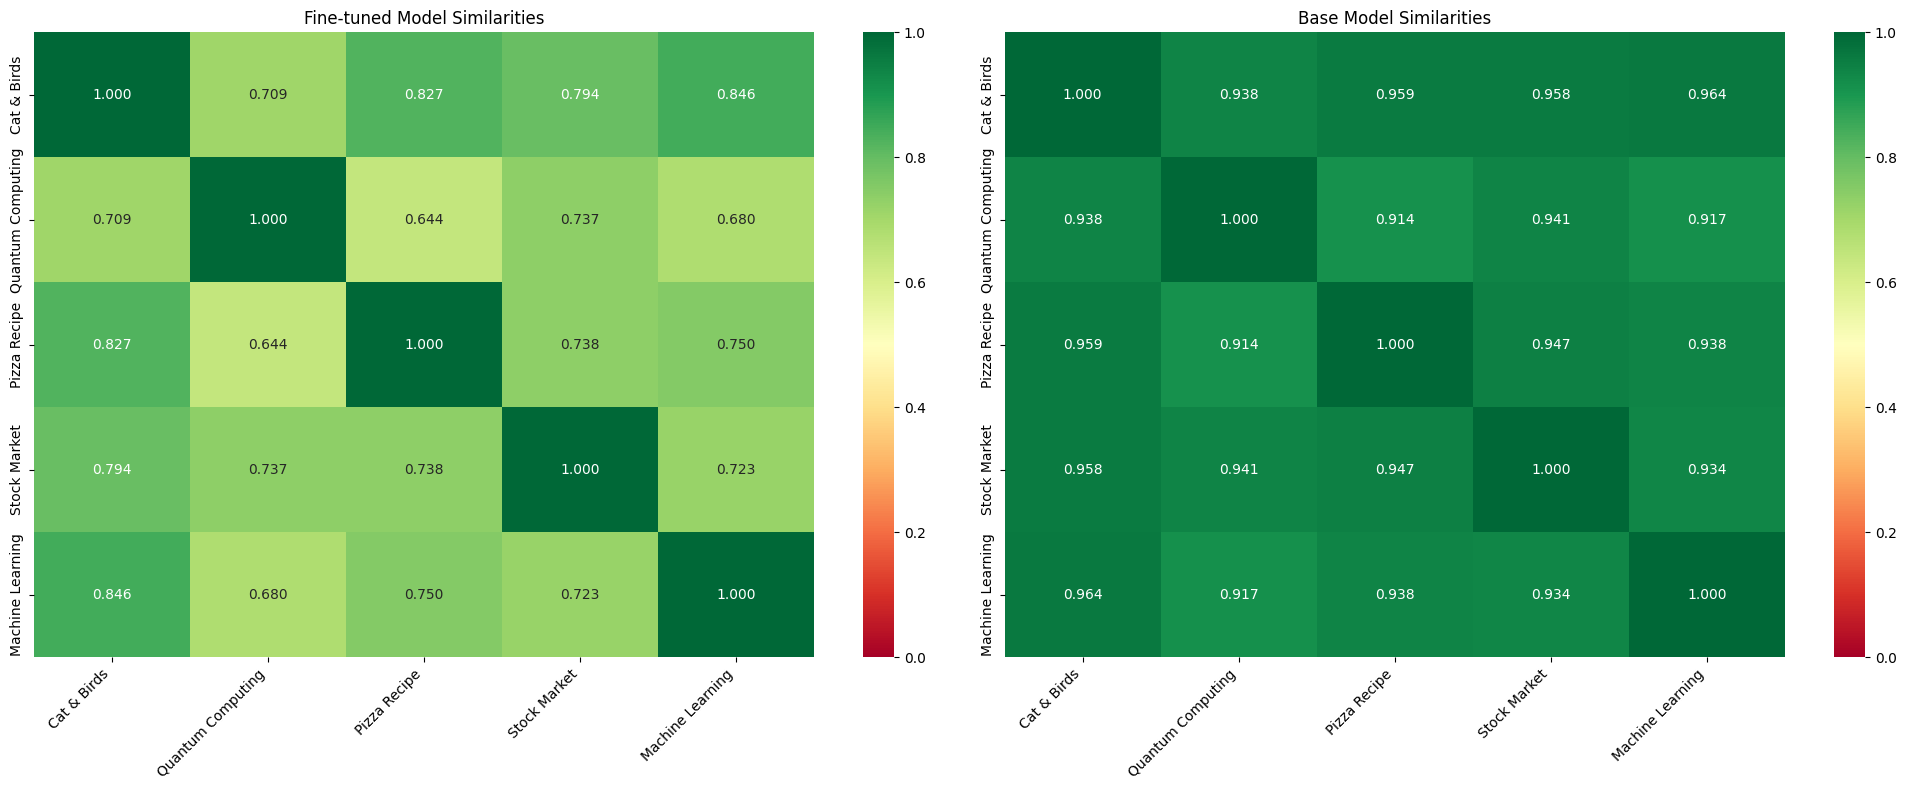

In [71]:
compare_plot(sentences)